# ENV

In [1]:
%pip install 'git+https://github.com/facebookresearch/detectron2.git'
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html
#!python -m pip install detectron2==0.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-13yuqgp3
     |████████████████████████████████| 48 kB 445 kB/s 
     |████████████████████████████████| 66 kB 1.4 MB/s 
     |████████████████████████████████| 112 kB 3.2 MB/s 
  Created wheel for detectron2: filename=detectron2-0.4-cp37-cp37m-linux_x86_64.whl size=4757675 sha256=b7fb73b0e4a5a4df012badbe94fee2bd083d3a3c5eccff6112d7fb55103da246
  Stored in directory: /tmp/pip-ephem-wheel-cache-d26pcjip/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210423-py3-none-any.whl size=59444 sha256=44b005cc4cb7f902810314b76599b51dd19faa27b17f7de50f4759cce3077df8
  Stored in directory: /root/.cache/pip/wheels/d1/9c/88/651728cb2ab468eb1b345b888428f160af56e49c6655bd2dc7
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=273768 sha256=09598047ed7bdc56f1d31c685a05de1a45741d1a1a408500189063b18c999a6b
  

In [2]:
#!pip install albumentations==0.5.2 pyyaml==5.1

In [3]:
!mkdir models logs configs 

In [4]:
!nvidia-smi

Fri Apr 23 14:51:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports and utils

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from typing import List, Optional, Union
from detectron2.data.transforms import Transform as T
import torch
import torchvision
import albumentations as A
#from albumentations.augmentations.transforms import Sharpen
#from albumentations.pytorch.transforms import ToTensorV2


import detectron2
from detectron2.data.datasets import register_coco_instances
from detectron2.data import transforms as T
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_test_loader , build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import detection_utils as utils
from detectron2.config import configurable
from detectron2.engine.hooks import EvalHook
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.logger import setup_logger
setup_logger()

from sklearn.model_selection import KFold,StratifiedKFold,StratifiedShuffleSplit,GroupKFold

import matplotlib.pyplot as plt
import cv2
import json
import io
import os
import copy
import random
from IPython.display import FileLink, FileLinks
import yaml
from abc import ABC,ABCMeta, abstractmethod

# Config

In [6]:
class Config(metaclass=ABCMeta):
    general={
        "DATASET_PATH" : "../input/tacotrashdataset",
        "LOGS_PATH" : "logs",
        "MODELS_PATH" : "models",
        "CONFIG_PATH" : "configs",
        "seed" : 42,
        "n_folds" : 5,
        "tool" : "detectron2",
        "experiment_id" : "24-03-2021",
        "category" : "super_category",
        "augmentations" : True,
        "TTA" : False
        
    }
    model={
        "base_lr" : 0.0004,
        "num_classes" : 29, #29 if super category 60 if normal category 
        "model_name" : "faster_rcnn_R_101_FPN_3x",
        "batchsize_per_image" : 1024,
        "images_per_batch" : 4,
        "epochs" : 9,
    }

    @staticmethod
    def dump(config,path="config.yaml"):
        stream = open(path, 'w')
        yaml.dump(config,stream)
        stream.close()
    
    @staticmethod
    def load(path="config.yaml"):
        stream = open(path, 'r')
        config=yaml.load(stream)
        stream.close()
        return config

global_config=Config()
c=global_config
def inject_config(funct):
    def function_wrapper(*args,**kwargs):
        return funct(global_config,*args,**kwargs)  
    return function_wrapper
    

In [7]:
Config.dump(global_config.general,os.path.join(global_config.general["CONFIG_PATH"],"global_config.yaml"))
Config.dump(global_config.model,os.path.join(global_config.general["CONFIG_PATH"],"model_config.yaml"))

# SEED

In [8]:
@inject_config
def seed_all(config):
    seed_value=config.general["seed"]
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

# FIX annotation duplicated ids and negative bboxes

repeated annotations idx 

308 => 0

4039  =>2197


In [9]:
annot=json.load(open(os.path.join(global_config.general["DATASET_PATH"],"data/annotations.json")))
annot["annotations"][308]["id"]=0
annot["annotations"][4039]["id"]=2197

## delete negative BBOX

In [10]:
annot_to_delete=[]
for idx,annotation in enumerate(annot["annotations"]):
    if (annotation["bbox"][0]<0 or annotation["bbox"][1]<0 or
        annotation["bbox"][2]<0 or annotation["bbox"][3]<0):
        annot_to_delete.append(idx)
for pos,idx in enumerate(annot_to_delete):
    del annot["annotations"][idx-pos]


In [11]:
json.dump(annot,open("new_annotations.json","w"))

# Annotation Preprocess and Viz

## Categories and Super categories dict

In [12]:
categories={ annotation["id"] : annotation["name"] for annotation in annot["categories"]}
super_categories={ annotation["id"] : annotation["supercategory"] for annotation in annot["categories"]}

In [13]:
super_categories

{0: 'Aluminium foil',
 1: 'Battery',
 2: 'Blister pack',
 3: 'Blister pack',
 4: 'Bottle',
 5: 'Bottle',
 6: 'Bottle',
 7: 'Bottle cap',
 8: 'Bottle cap',
 9: 'Broken glass',
 10: 'Can',
 11: 'Can',
 12: 'Can',
 13: 'Carton',
 14: 'Carton',
 15: 'Carton',
 16: 'Carton',
 17: 'Carton',
 18: 'Carton',
 19: 'Carton',
 20: 'Cup',
 21: 'Cup',
 22: 'Cup',
 23: 'Cup',
 24: 'Cup',
 25: 'Food waste',
 26: 'Glass jar',
 27: 'Lid',
 28: 'Lid',
 29: 'Other plastic',
 30: 'Paper',
 31: 'Paper',
 32: 'Paper',
 33: 'Paper',
 34: 'Paper bag',
 35: 'Paper bag',
 36: 'Plastic bag & wrapper',
 37: 'Plastic bag & wrapper',
 38: 'Plastic bag & wrapper',
 39: 'Plastic bag & wrapper',
 40: 'Plastic bag & wrapper',
 41: 'Plastic bag & wrapper',
 42: 'Plastic bag & wrapper',
 43: 'Plastic container',
 44: 'Plastic container',
 45: 'Plastic container',
 46: 'Plastic container',
 47: 'Plastic container',
 48: 'Plastic glooves',
 49: 'Plastic utensils',
 50: 'Pop tab',
 51: 'Rope & strings',
 52: 'Scrap metal',
 

## Preprocess

In [14]:
annot_df=pd.DataFrame(annot["annotations"])
images_df=pd.DataFrame(annot["images"])

In [15]:
images_df.describe()

,id,width,height
count,1500.000000,1500.00000,1500.000000
mean,749.500000,2824.88400,3222.825333
std,433.157015,758.65017,802.357852
min,0.000000,842.00000,474.000000
25%,374.750000,2448.00000,2448.000000
50%,749.500000,2448.00000,3264.000000
75%,1124.250000,3264.00000,4000.000000
max,1499.000000,6000.00000,5312.000000


In [16]:
"""
for code testing
"""
#annot_df=annot_df.head(200)

'\nfor code testing\n'

In [17]:
annot_df["category"]=annot_df["category_id"].apply(lambda value : categories[value])
annot_df["super_category"]=annot_df["category_id"].apply(lambda value : super_categories[value])
super_category_to_index={value : key for key,value in enumerate(annot_df["super_category"].unique())}
annot_df["super_category_id"]=annot_df["super_category"].apply(lambda value : super_category_to_index[value])
annot_df["normal_category_id"]=annot_df["category_id"]
annot_df["normal_category"]=annot_df["category"]
if c.general["category"] != "normal_category":
    annot_df["category_id"]=annot_df["super_category_id"]
    annot_df["category"]=annot_df["super_category"]
    annot_cat=annot_df.groupby("category_id")[["category_id","category","super_category"]].first()
    annot_cat.columns=["id","name","supercategory"]
    annot["categories"]=annot_cat.to_dict("records")

                       

In [18]:
categories = {}
for id , name in zip(annot_df["category_id"],annot_df["category"]):
    categories[id]=name

In [19]:
categories

{0: 'Bottle',
 1: 'Carton',
 2: 'Bottle cap',
 3: 'Can',
 4: 'Pop tab',
 5: 'Cup',
 6: 'Plastic bag & wrapper',
 7: 'Styrofoam piece',
 8: 'Other plastic',
 9: 'Plastic container',
 10: 'Paper',
 11: 'Lid',
 12: 'Straw',
 13: 'Paper bag',
 14: 'Broken glass',
 15: 'Plastic utensils',
 16: 'Glass jar',
 17: 'Food waste',
 18: 'Squeezable tube',
 19: 'Shoe',
 20: 'Aluminium foil',
 21: 'Unlabeled litter',
 22: 'Blister pack',
 23: 'Battery',
 24: 'Rope & strings',
 25: 'Cigarette',
 26: 'Scrap metal',
 27: 'Plastic glooves'}

## VIZ

In [20]:
annot_df.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,category,super_category,super_category_id,normal_category_id,normal_category
0,1,0,0,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Bottle,Bottle,0,6,Glass bottle
1,2,1,1,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1071259.5,"[1.0, 457.0, 1429.0, 1519.0]",0,Carton,Carton,1,18,Meal carton
2,3,1,1,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",99583.5,"[531.0, 292.0, 1006.0, 672.0]",0,Carton,Carton,1,14,Other carton
3,4,2,0,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Bottle,Bottle,0,5,Clear plastic bottle
4,5,2,2,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",915.0,"[632.0, 989.0, 44.0, 51.0]",0,Bottle cap,Bottle cap,2,7,Plastic bottle cap


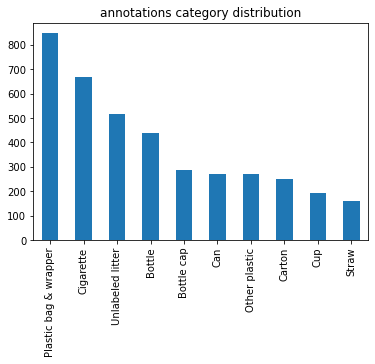

In [21]:
annot_df["category"].value_counts().head(10).plot(kind="bar",title="annotations category distribution")

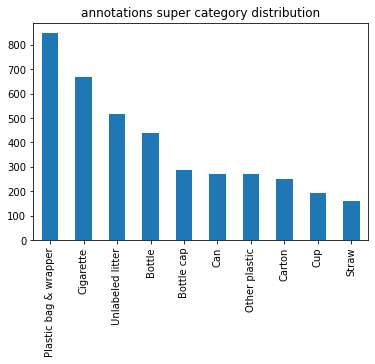

In [22]:
annot_df["super_category"].value_counts().head(10).plot(kind="bar",title="annotations super category distribution")

# Kfold

In [23]:
@inject_config
def kfold_split(config):
    seed_all()
    annot_df["folds"]=-1
    kf = GroupKFold(n_splits=config.general["n_folds"])
    #kf = StratifiedShuffleSplit(n_splits=Config.n_folds,test_size=Config.test_size, random_state=Config.random_state, )
    #kf = StratifiedShuffleSplit(n_splits=10,test_size=0.1, random_state=Config.random_state, )

    for fold, (_, val_index) in enumerate(kf.split(annot_df,groups=annot_df["image_id"])):
            annot_df.loc[val_index, "folds"] = fold

In [24]:
kfold_split()

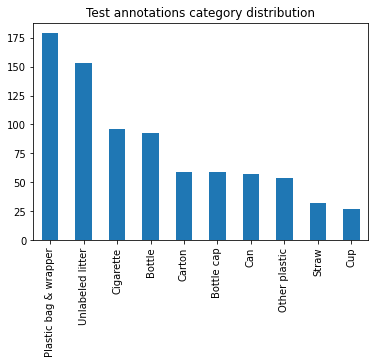

In [25]:
annot_df[annot_df["folds"]==0]["category"].value_counts().head(10).plot(kind="bar",title="Test annotations category distribution")

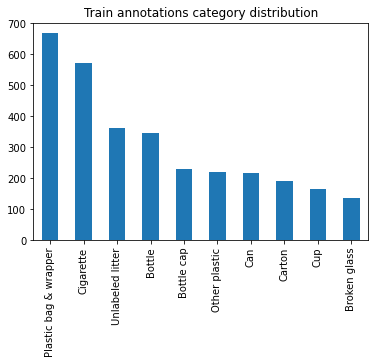

In [26]:
annot_df[annot_df["folds"]!=0]["category"].value_counts().head(10).plot(kind="bar",title="Train annotations category distribution")

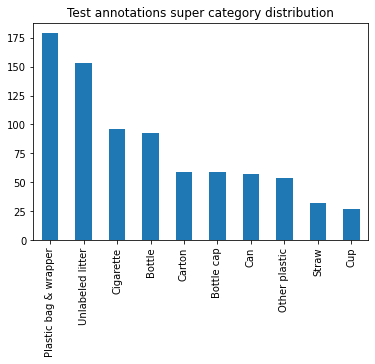

In [27]:
annot_df[annot_df["folds"]==0]["super_category"].value_counts().head(10).plot(kind="bar",title="Test annotations super category distribution")

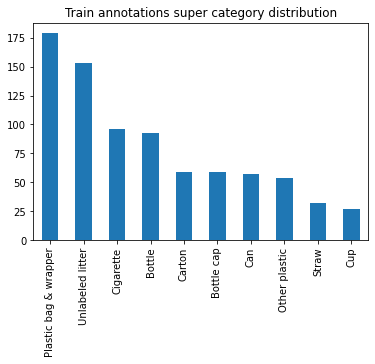

In [28]:
annot_df[annot_df["folds"]==0]["super_category"].value_counts().head(10).plot(kind="bar",title="Train annotations super category distribution")

# Register Dataset

In [29]:
@inject_config
def register_dataset(config,fold):
    train_dataset_name=f"my_dataset_train_{fold}"
    test_dataset_name=f"my_dataset_test_{fold}"
    train_dataset_file=f"my_dataset_train_{fold}.json"
    test_dataset_file=f"my_dataset_test_{fold}.json"
    
    train_annot_df=annot_df[annot_df["folds"]!=fold]
    test_annot_df=annot_df[annot_df["folds"]==fold]
    train_annot_df=train_annot_df.drop(["normal_category","normal_category_id"],axis=1)
    test_annot_df=test_annot_df.drop(["normal_category","normal_category_id"],axis=1)

    train_images_df=images_df[images_df["id"].apply(lambda i:True if i in list(train_annot_df["image_id"].unique()) else False)]
    test_images_df=images_df[images_df["id"].apply(lambda i:True if i in list(test_annot_df["image_id"].unique()) else False)]
    
    train_annot=annot.copy()
    test_annot=annot.copy()
    
    train_annot["annotations"]=train_annot_df.reset_index(drop=True).to_dict("records")
    train_annot["images"]=train_images_df.reset_index(drop=True).to_dict("records")
    test_annot["annotations"]=test_annot_df.reset_index(drop=True).to_dict("records")
    test_annot["images"]=test_images_df.reset_index(drop=True).to_dict("records")
    
    json.dump(train_annot,open(train_dataset_file,"w"))
    json.dump(test_annot,open(test_dataset_file,"w"))
    
    if train_dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(train_dataset_name)
        MetadataCatalog.remove(train_dataset_name)
    if test_dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(test_dataset_name)
        MetadataCatalog.remove(test_dataset_name)
        
    register_coco_instances(train_dataset_name, {}, train_dataset_file, os.path.join(config.general["DATASET_PATH"],"data"))
    register_coco_instances(test_dataset_name, {}, test_dataset_file, os.path.join(config.general["DATASET_PATH"],"data"))


# Preprocess and augmentations 

In [30]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6,**kwargs):
    # Stack X as [X,X,X]
    #print(X.shape)
    #X = np.squeeze(np.stack([X, X, X], axis=-2),axis=-1)
    X=X.transpose(1, 0, 2)
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V
  

class ToColor:
    def __init__(self,
                  mean=None,
                  std=None):
        self.mean=mean
        self.std = std
        

    def __call__(self, image,**kwargs):
        return mono_to_color(image,
                            self.mean,
                            self.std,
                            )

In [31]:
def get_train_transforms():
    return A.Compose(
        [
            #A.RandomSizedCrop(min_max_height=(1024, 1024), height=1024, width=1024, p=0.2),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit= 0.1, 
                                     val_shift_limit=0.1, p=0.8),
                A.RandomBrightnessContrast(brightness_limit=0.3, 
                                           contrast_limit=0.2, p=0.8),
            ],p=0.7),
            A.Rotate (limit=15, interpolation=1, border_mode=4, value=None, mask_value=None, p=0.8),
            
            #A.transforms.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomResizedCrop (1500, 1500, scale=(0.8, 0.8), ratio=(0.75, 1.3333333333333333), interpolation=1, always_apply=False, p=0.1),
            A.OneOf([
            A.Resize(height=1500, width=1500, p=0.2),
            A.LongestMaxSize(max_size=1500, p=0.2),
            A.SmallestMaxSize(max_size=1000, p=0.2),
            #A.SmallestMaxSize(max_size=1100, p=0.2),
                
            ], p=1),
            A.CLAHE(clip_limit=[1,4],p=1),
            #A.Lambda(ToColor(),p=1),
            #A.Cutout(num_holes=16, max_h_size=64, max_w_size=64, fill_value=0, p=0.1),
            
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='coco',
            min_area=0.5, 
            min_visibility=0.5,
            label_fields=['category_id']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            
            A.SmallestMaxSize(max_size=1000, p=1.0),
            A.CLAHE(clip_limit=[3,3],p=1),
            #A.Normalize(p=1),
            #A.Lambda(ToColor(),p=1),
            
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='coco',
            min_area=0.5, 
            min_visibility=0.5,
            label_fields=['category_id']
        )
    )

def get_transforms(train=True):
    if (train):
        return get_train_transforms()
    return get_valid_transforms()
albu_transformations=get_transforms(train=True)
#albu_transformations=None

In [32]:
class PersonalMapper (detectron2.data.DatasetMapper):
    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
        image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
        #utils.check_image_size(dataset_dict, image)

        
        
        ##### ADDED PART

        #print("dataset dict : ",dataset_dict)

        annos = [
            obj for obj in dataset_dict["annotations"]
        ]
        annos_bbox = [
            obj["bbox"] for obj in dataset_dict["annotations"]
        ]
        annos_categroy_id = [
            obj["category_id"] for obj in dataset_dict.pop("annotations")
        ]
        
        if albu_transformations is not None:
            transform_list=get_transforms(self.is_train)
            image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            transform_result=transform_list(image=image,bboxes=annos_bbox,category_id=annos_categroy_id)
            image=cv2.cvtColor(transform_result["image"], cv2.COLOR_RGB2BGR)
            annos=[annos[i] for i in range(len(transform_result["bboxes"]))]
            for i in range(len(annos)):
                annos[i]["bbox"]=list(transform_result["bboxes"][i])
                annos[i]["category_id"]=transform_result["category_id"][i]
        
        dataset_dict["annotations"]=annos
        
        
        ##### ADDED PART
        
        # USER: Remove if you don't do semantic/panoptic segmentation.
        if "sem_seg_file_name" in dataset_dict:
            sem_seg_gt = utils.read_image(dataset_dict.pop("sem_seg_file_name"), "L").squeeze(2)
        else:
            sem_seg_gt = None

        aug_input = T.AugInput(image, sem_seg=sem_seg_gt)
        transforms = self.augmentations(aug_input)
        image, sem_seg_gt = aug_input.image, aug_input.sem_seg

        image_shape = image.shape[:2]  # h, w
        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))
        if sem_seg_gt is not None:
            dataset_dict["sem_seg"] = torch.as_tensor(sem_seg_gt.astype("long"))

        # USER: Remove if you don't use pre-computed proposals.
        # Most users would not need this feature.
        if self.proposal_topk is not None:
            utils.transform_proposals(
                dataset_dict, image_shape, transforms, proposal_topk=self.proposal_topk
            )

        if not self.is_train:
            # USER: Modify this if you want to keep them for some reason.
            dataset_dict.pop("annotations", None)
            dataset_dict.pop("sem_seg_file_name", None)
            return dataset_dict

        if "annotations" in dataset_dict:
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.use_instance_mask:
                    anno.pop("segmentation", None)
                if not self.use_keypoint:
                    anno.pop("keypoints", None)

            # USER: Implement additional transformations if you have other types of data
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
                )
                for obj in dataset_dict.pop("annotations")
                if obj.get("iscrowd", 0) == 0
            ]
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.instance_mask_format
            )

            # After transforms such as cropping are applied, the bounding box may no longer
            # tightly bound the object. As an example, imagine a triangle object
            # [(0,0), (2,0), (0,2)] cropped by a box [(1,0),(2,2)] (XYXY format). The tight
            # bounding box of the cropped triangle should be [(1,0),(2,1)], which is not equal to
            # the intersection of original bounding box and the cropping box.
            if self.recompute_boxes:
                instances.gt_boxes = instances.gt_masks.get_bounding_boxes()
            dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [33]:
def show_rand_image(train_ds,meta_ds):
    """
    Can't find solution to show image with augs
    """
    mapper=PersonalMapper(cfg,is_train=True, augmentations=[])
    plt.figure(figsize=(16,20))
    for d in random.sample(ds, 1):
        d=mapper(d)
        d["annotations"]=[]
        #print("d : ",d["instances"].get_fields())

        for bbox,classes in zip(d["instances"].get_fields()["gt_boxes"],
                        d["instances"].get_fields()["gt_classes"]):
            #print("bbox : ",bbox.numpy())
            instance={
                'iscrowd': 0,
                'bbox': list(bbox.numpy()),
                'bbox_mode': detectron2.structures.BoxMode.XYXY_ABS,
                'category_id' : classes
            }
            d["annotations"].append(instance)
        #print("annotations : ",d["annotations"])
        img = d["image"]
        visualizer = Visualizer(img.numpy().transpose(1, 2, 0), metadata=meta, scale=0.5)
        out = visualizer.draw_dataset_dict(d)
        plt.imshow(out.get_image()[:, :, ::-1])

In [34]:
#show_rand_image(ds,meta)

# STATS and VIZ

In [35]:
meta_df=pd.read_csv("../input/tacotrashdataset/meta_df.csv")

In [36]:
register_coco_instances("my_dataset", {}, "new_annotations.json", os.path.join(global_config.general["DATASET_PATH"],"data"))

In [37]:
ds=DatasetCatalog.get("my_dataset")
meta=MetadataCatalog.get("my_dataset")

WARNING [04/23 14:51:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 14:51:18 d2.data.datasets.coco]: Loaded 1500 images in COCO format from new_annotations.json


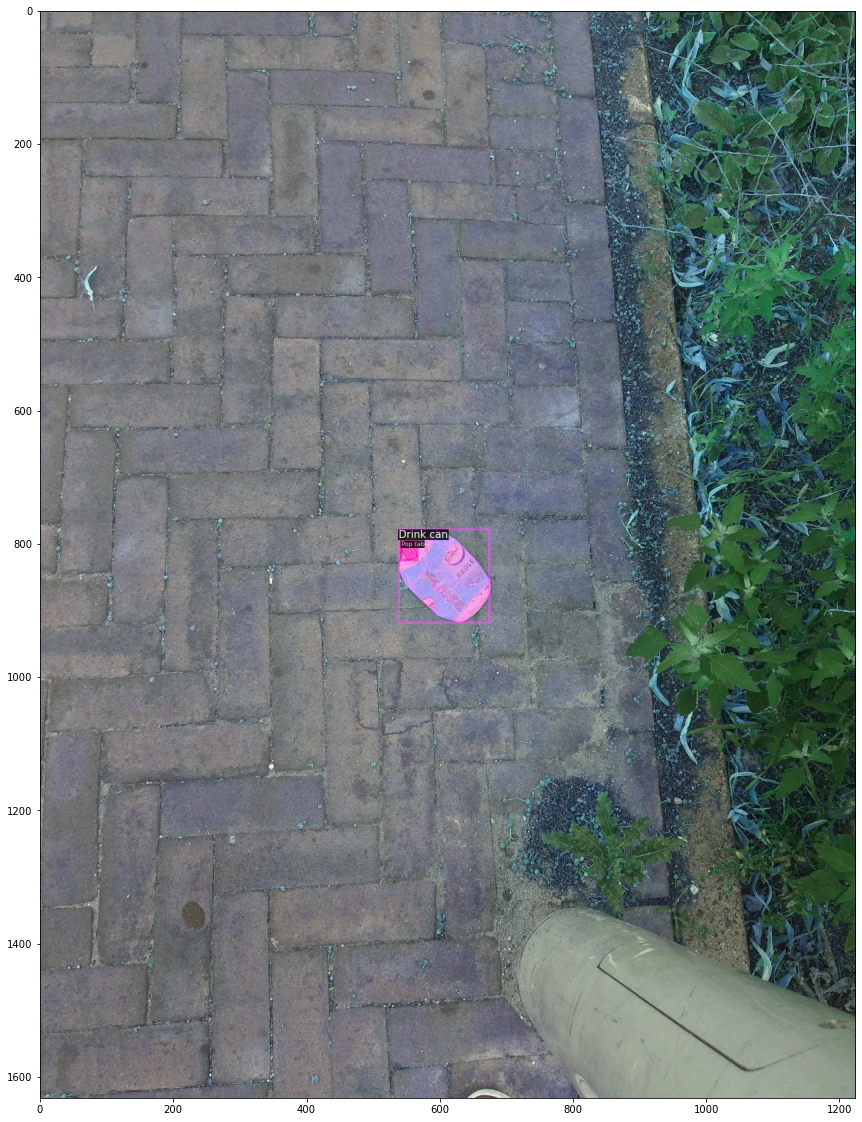

In [38]:
plt.figure(figsize=(16,20))
for d in random.sample(ds, 1):
    #print("d : ",d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=meta, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

In [39]:
#show_rand_image(ds,meta)

# Build Trainer

In [40]:
class PersonalTrainer (detectron2.engine.defaults.DefaultTrainer):
    
    def __init__(self, cfg , config=c):
        super().__init__(cfg)
        self.metric=0
        self.checkpointer.save_dir=config.general["MODELS_PATH"]

        
    def build_hooks(self):
        hooks = super().build_hooks()
        def save_best_model():
            
            metric=self.test(self.cfg, self.model)["bbox"]["AP50"]
            if(metric>self.metric):
                self.metric=metric
                self.checkpointer.save("best_model") # it will add .pth alone
                
        steps_per_epoch=annot_df.shape[0]//global_config.model["images_per_batch"]
        model_checkpointer=EvalHook(steps_per_epoch, save_best_model)
        hooks.insert(-1,model_checkpointer)
        return hooks
    
    @classmethod
    def build_train_loader(cls, cfg):
        
        #return build_detection_train_loader(cfg,mapper=DatasetMapper(cfg,is_train=True,))
        return build_detection_train_loader(cfg,mapper=PersonalMapper(cfg,is_train=True,augmentations=[]))
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        
        #return build_detection_test_loader( cfg,dataset_name,mapper=DatasetMapper(cfg,is_train=False,))
        return build_detection_test_loader( cfg,dataset_name,mapper=PersonalMapper(cfg,is_train=False,augmentations=[]))

    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=None)

# Prepare config params

In [41]:
@inject_config
def get_config(config,fold=0):
    steps_per_epoch=annot_df.shape[0]//config.model["images_per_batch"]
    train_dataset_name=f"my_dataset_train_{fold}"
    test_dataset_name=f"my_dataset_test_{fold}"
    cfg = get_cfg()
    cfg.MODEL.DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
    cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{config.model['model_name']}.yaml"))
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = (test_dataset_name,)
    cfg.DATALOADER.NUM_WORKERS = 4
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{config.model['model_name']}.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = config.model["images_per_batch"]
    #cfg.SOLVER.IMS_PER_BATCH = 100
    cfg.SOLVER.BASE_LR = config.model["base_lr"]  # pick a good LR
    cfg.SOLVER.MAX_ITER = steps_per_epoch*config.model["epochs"]  # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    #cfg.SOLVER.MAX_ITER = 100
    cfg.SOLVER.STEPS = (steps_per_epoch*8,)
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = config.model["batchsize_per_image"]   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = config.model["num_classes"]  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    cfg.TEST.EVAL_PERIOD=0
    #cfg.TEST.EVAL_PERIOD=steps_per_epoch
    cfg.OUTPUT_DIR = config.general["LOGS_PATH"]
    #cfg.TEST.EVALUATION_PERIOD=95
    cfg.OUTPUT_DIR_BEST=f'{config.general["LOGS_PATH"]}'
    cfg.SOLVER.AMP.ENABLED = True
    #cfg.MODEL.WEIGHTS = "../input/trash-detection-output/models/best_model.pth"
    cfg.MODEL.WEIGHTS = "../input/trash-taco-heavy-augs/models/best_model.pth"

    cfg.SEED = config.general["seed"]

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    os.makedirs(cfg.OUTPUT_DIR_BEST, exist_ok=True)
    return cfg


In [42]:
cfg=get_config()

# Prepare trainer

In [43]:
@inject_config
def train(config,fold):
    seed_all()
    register_dataset(fold)
    cfg=get_config(fold)
    #trainer = DefaultTrainer(cfg)
    trainer = PersonalTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.evaluator = COCOEvaluator(f"my_dataset_test_{fold}", ("bbox",), False, output_dir=None)
    trainer.train()
    

In [44]:
train(0)

[04/23 14:51:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  num_fg = fg_inds.nonzero().numel()


[04/23 14:52:41 d2.utils.events]:  eta: 7:53:08  iter: 19  total_loss: 0.1817  loss_cls: 0.08641  loss_box_reg: 0.05543  loss_rpn_cls: 0.005724  loss_rpn_loc: 0.01778  time: 2.6486  data_time: 0.2816  lr: 7.9924e-06  max_mem: 9674M
[04/23 14:53:38 d2.utils.events]:  eta: 7:55:19  iter: 39  total_loss: 0.1269  loss_cls: 0.05843  loss_box_reg: 0.04105  loss_rpn_cls: 0.004344  loss_rpn_loc: 0.01406  time: 2.7645  data_time: 0.1334  lr: 1.5984e-05  max_mem: 9674M
[04/23 14:54:29 d2.utils.events]:  eta: 7:53:08  iter: 59  total_loss: 0.1423  loss_cls: 0.06726  loss_box_reg: 0.0467  loss_rpn_cls: 0.004455  loss_rpn_loc: 0.01478  time: 2.6961  data_time: 0.0206  lr: 2.3976e-05  max_mem: 9674M
[04/23 14:55:23 d2.utils.events]:  eta: 7:49:14  iter: 79  total_loss: 0.1784  loss_cls: 0.0796  loss_box_reg: 0.05247  loss_rpn_cls: 0.005372  loss_rpn_loc: 0.01031  time: 2.6926  data_time: 0.1364  lr: 3.1968e-05  max_mem: 9674M
[04/23 14:56:18 d2.utils.events]:  eta: 7:51:13  iter: 99  total_loss: 0.1

# Prepare Output

In [45]:
with open(os.path.join(global_config.general["CONFIG_PATH"],"detectron_config.yaml"),"w") as f:
    f.write(get_config().dump())

In [46]:
%ls logs

events.out.tfevents.1619189497.efd2f9706f28.16.0  metrics.json


In [47]:
%ls models

best_model.pth   model_0004999.pth  model_final.pth
last_checkpoint  model_0009999.pth


In [48]:
%ls configs

detectron_config.yaml  global_config.yaml  model_config.yaml


In [49]:
# Look at training curves in tensorboard:
#%load_ext tensorboard
#%tensorboard --logdir output

# Test Dataset

In [50]:
metrics={}

In [51]:
cfg=get_config()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(global_config.general["MODELS_PATH"], "best_model.pth")  # path to the model we just trained
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth.pth")  # path to the model we just trained
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
model = build_model(cfg)
m=DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

In [52]:
evaluator = COCOEvaluator("my_dataset_test_0", ("bbox",), False, output_dir=global_config.general["LOGS_PATH"])
val_loader = build_detection_test_loader(cfg, "my_dataset_test_0")
train_metric=inference_on_dataset(model, val_loader, evaluator)
metrics["train_metric"]=train_metric

WARNING [04/23 23:20:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 23:20:11 d2.data.datasets.coco]: Loaded 299 images in COCO format from my_dataset_test_0.json
[04/23 23:20:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/23 23:20:11 d2.data.common]: Serializing 299 elements to byte tensors and concatenating them all ...
[04/23 23:20:11 d2.data.common]: Serialized dataset takes 0.51 MiB
[04/23 23:20:11 d2.evaluation.evaluator]: Start inference on 299 images
[04/23 23:20:14 d2.evaluation.evaluator]: Inference done 11/299. 0.1550 s / img. ETA=0:01:11
[04/23 23:20:20 d2.evaluation.evaluator]: Inference done 25/299. 0.1616 s / img. ETA=0:01:34
[04/23 23:20:25 d2.evaluation.evaluator]: Inference done 41/299. 0.1673 s / img. ETA=0:01:30
[04/23 23:20:32 d2.evaluation.evaluator]: Inference done 52

In [53]:
evaluator = COCOEvaluator("my_dataset_train_0", ("bbox",), False, output_dir=global_config.general["LOGS_PATH"])
val_loader = build_detection_test_loader(cfg, "my_dataset_train_0")
valid_metric=inference_on_dataset(model, val_loader, evaluator)
metrics["valid_metric"]=valid_metric

WARNING [04/23 23:22:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 23:22:20 d2.data.datasets.coco]: Loaded 1201 images in COCO format from my_dataset_train_0.json
[04/23 23:22:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/23 23:22:20 d2.data.common]: Serializing 1201 elements to byte tensors and concatenating them all ...
[04/23 23:22:20 d2.data.common]: Serialized dataset takes 1.71 MiB
[04/23 23:22:20 d2.evaluation.evaluator]: Start inference on 1201 images
[04/23 23:22:24 d2.evaluation.evaluator]: Inference done 11/1201. 0.1930 s / img. ETA=0:04:00
[04/23 23:22:30 d2.evaluation.evaluator]: Inference done 39/1201. 0.1619 s / img. ETA=0:03:38
[04/23 23:22:35 d2.evaluation.evaluator]: Inference done 52/1201. 0.1634 s / img. ETA=0:04:40
[04/23 23:22:40 d2.evaluation.evaluator]: Inference 

In [54]:
Config.dump(metrics,os.path.join(global_config.general["LOGS_PATH"],"metrics.yaml"))